In [1]:
# Clickstream Conversion Analysis

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score,
    silhouette_score, davies_bouldin_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

from IPython.display import display, Markdown

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except:
    SMOTE_AVAILABLE = False


In [2]:
# DATA GENERATION

def create_data(num_sessions=2000, max_clicks_per_session=8):
    rng = np.random.default_rng(42)
    rows = []
    session_id = 1000
    for _ in range(num_sessions):
        clicks = int(rng.integers(1, max_clicks_per_session+1))
        year = 2008
        month = int(rng.integers(4, 9))
        day = int(rng.integers(1, 29))
        country = int(rng.integers(1, 48))
        main_cat = int(rng.integers(1, 5))
        colour = int(rng.integers(1, 15))
        location = int(rng.integers(1, 7))
        model_photo = int(rng.integers(1, 3))
        price_flag = int(rng.choice([0,1]))
        page2_model = int(rng.integers(1, 218))

        for order in range(1, clicks+1):
            price = float(rng.uniform(5, 500))
            page = int(rng.integers(1, 6))
            rows.append({
                'YEAR': year,
                'MONTH': month,
                'DAY': day,
                'ORDER': order,
                'COUNTRY': country,
                'SESSION_ID': session_id,
                'PAGE_1_MAIN_CATEGORY': main_cat,
                'PAGE_2_CLOTHING_MODEL': page2_model,
                'COLOUR': colour,
                'LOCATION': location,
                'MODEL_PHOTOGRAPHY': model_photo,
                'PRICE': round(price, 2),
                'PRICE_2_HIGHER_THAN_AVG': price_flag,
                'PAGE': page,
            })
        session_id += 1

    df = pd.DataFrame(rows)

    # Inject missing values
    for col in ['COUNTRY','PRICE']:
        df.loc[df.sample(frac=0.015).index, col] = np.nan

    df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])
    df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek

    # Session features
    df['SESSION_LENGTH'] = df.groupby('SESSION_ID')['ORDER'].transform('max')
    df['BOUNCE'] = (df['SESSION_LENGTH']==1).astype(int)
    revisits = (df.groupby('SESSION_ID')['DAY'].transform('nunique') > 1).astype(int)
    df['REVISIT'] = revisits

    # Targets
    df['PURCHASE_COMPLETED'] = np.where(
        (df['PRICE'].fillna(df['PRICE'].median())<120) &
        (df['SESSION_LENGTH']>=3) & (df['PAGE']<=3), 1, 0
    )
    df['REVENUE'] = (df['PRICE'].fillna(df['PRICE'].median()) * (1+0.05*(df['SESSION_LENGTH']-1))).round(2)

    return df

train_df = create_data()


Exploratory Data Analysis (EDA)

We start by inspecting the dataset, its distributions, and key relationships.

,YEAR,MONTH,DAY,ORDER,COUNTRY,SESSION_ID,PAGE_1_MAIN_CATEGORY,PAGE_2_CLOTHING_MODEL,COLOUR,LOCATION,...,PRICE,PRICE_2_HIGHER_THAN_AVG,PAGE,DATE,DAY_OF_WEEK,SESSION_LENGTH,BOUNCE,REVISIT,PURCHASE_COMPLETED,REVENUE
0,2008,7,19,1,21.0,1000,2,21,13,1,...,487.93,0,4,2008-07-19,5,1,1,0,0,487.93
1,2008,7,23,1,25.0,1001,1,40,12,3,...,323.71,0,5,2008-07-23,2,7,0,0,0,420.82
2,2008,7,23,2,25.0,1001,1,40,12,3,...,412.27,0,3,2008-07-23,2,7,0,0,0,535.95
3,2008,7,23,3,25.0,1001,1,40,12,3,...,117.48,0,3,2008-07-23,2,7,0,0,1,152.72
4,2008,7,23,4,25.0,1001,1,40,12,3,...,279.52,0,5,2008-07-23,2,7,0,0,0,363.38


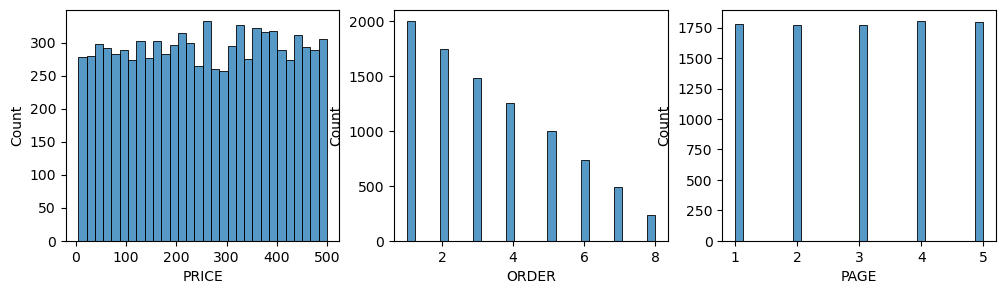

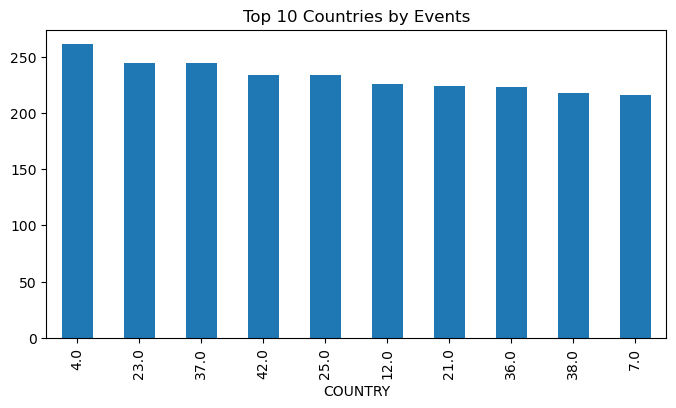

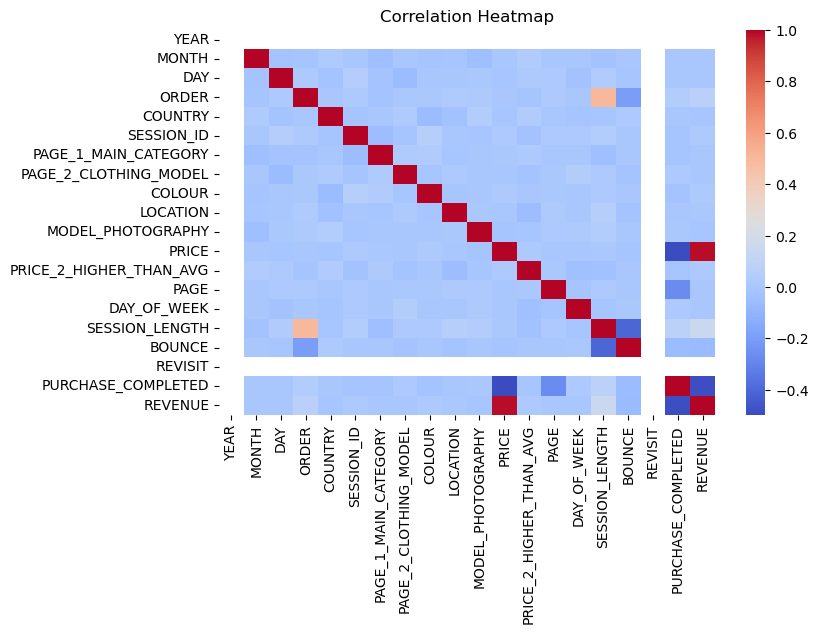

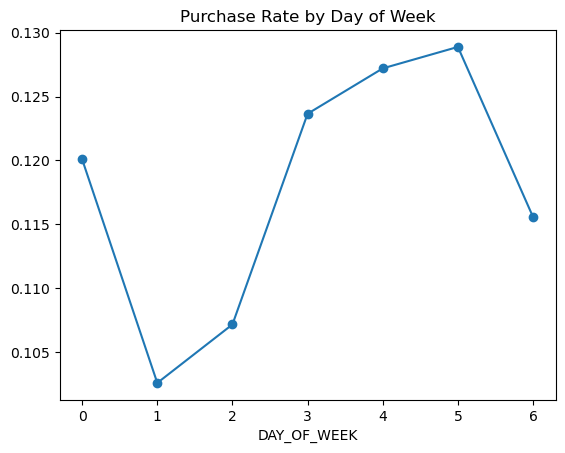

In [3]:
# EXPLORATORY DATA ANALYSIS

display(Markdown("Exploratory Data Analysis (EDA)"))
display(Markdown("We start by inspecting the dataset, its distributions, and key relationships."))

display(train_df.head())

fig, ax = plt.subplots(1,3, figsize=(12,3))
for i,col in enumerate(['PRICE','ORDER','PAGE']):
    sns.histplot(train_df[col], bins=30, ax=ax[i])
plt.show()

plt.figure(figsize=(8,4))
top_countries = train_df['COUNTRY'].value_counts().head(10)
top_countries.plot(kind='bar')
plt.title("Top 10 Countries by Events")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(train_df.select_dtypes(include=np.number).corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

rate = train_df.groupby('DAY_OF_WEEK')['PURCHASE_COMPLETED'].mean()
rate.plot(marker='o')
plt.title("Purchase Rate by Day of Week")
plt.show()


In [4]:
# CLASSIFICATION

display(Markdown("Classification Models"))
display(Markdown("We train multiple classifiers to predict whether a session results in a purchase (1) or not (0)."))

num_features = ['ORDER','PRICE','PAGE','DAY_OF_WEEK','SESSION_LENGTH']
cat_features = ['COUNTRY','PAGE_1_MAIN_CATEGORY','COLOUR','LOCATION','MODEL_PHOTOGRAPHY','PRICE_2_HIGHER_THAN_AVG']

pre = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_features),

    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])

X = train_df[num_features+cat_features]
y_cls = train_df['PURCHASE_COMPLETED']
y_reg = train_df['REVENUE']

X_train, X_val, y_train, y_val = train_test_split(X,y_cls,test_size=0.2, stratify=y_cls, random_state=42)

if SMOTE_AVAILABLE:
    sm = SMOTE(random_state=42)
    X_train_proc = pre.fit_transform(X_train)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_proc, y_train)
else:
    X_train_bal = pre.fit_transform(X_train)
    y_train_bal = y_train

X_val_proc = pre.transform(X_val)

cls_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)
}
if XGB_AVAILABLE:
    cls_models['XGBoost'] = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

cls_results = {}
for name, model in cls_models.items():
    model.fit(X_train_bal, y_train_bal)
    preds = model.predict(X_val_proc)
    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, pos_label=1)
    rec = recall_score(y_val, preds, pos_label=1)
    f1 = f1_score(y_val, preds, pos_label=1)
    auc = np.nan
    if hasattr(model,'predict_proba'):
        probs = model.predict_proba(X_val_proc)
        auc = roc_auc_score(y_val, probs[:,1])
    cls_results[name] = dict(acc=acc,prec=prec,rec=rec,f1=f1,auc=auc)

cls_df = pd.DataFrame(cls_results).T
display(cls_df)


Classification Models

We train multiple classifiers to predict whether a session results in a purchase (1) or not (0).

C:\Users\Kiran Kumar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:08:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,acc,prec,rec,f1,auc
Logistic Regression,0.917133,0.593373,0.938095,0.726937,0.981892
Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
XGBoost,0.998320,0.985915,1.000000,0.992908,0.999982


In [5]:
# REGRESSION

display(Markdown("Regression Models"))
display(Markdown("We estimate the expected session revenue using regression models."))

X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X,y_reg,test_size=0.2, random_state=42)
X_train_rp = pre.fit_transform(X_train_r)
X_val_rp = pre.transform(X_val_r)

reg_models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor()
}

reg_results = {}
for name, model in reg_models.items():
    model.fit(X_train_rp, y_train_r)
    preds = model.predict(X_val_rp)
    rmse = mean_squared_error(y_val_r, preds, squared=False)
    mae = mean_absolute_error(y_val_r, preds)
    r2 = r2_score(y_val_r, preds)
    reg_results[name] = dict(rmse=rmse,mae=mae,r2=r2)

reg_df = pd.DataFrame(reg_results).T
display(reg_df)


Regression Models

We estimate the expected session revenue using regression models.

C:\Users\Kiran Kumar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Kiran Kumar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Kiran Kumar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Kiran Kumar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

,rmse,mae,r2
Linear,14.010599,10.117034,0.993696
Ridge,14.010009,10.119745,0.993697
Lasso,14.032703,10.272615,0.993676
Gradient Boosting,2.519947,1.965521,0.999796


In [6]:
# CLUSTERING

display(Markdown("Clustering"))
display(Markdown("We group sessions into segments using KMeans clustering, then validate clusters with Silhouette and Davies–Bouldin scores."))

clust_features = ['ORDER','PRICE','PAGE_1_MAIN_CATEGORY','COLOUR']
cl_pre = ColumnTransformer([
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())]), ['ORDER','PRICE']),
    ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OneHotEncoder())]), ['PAGE_1_MAIN_CATEGORY','COLOUR'])
])
Xc = cl_pre.fit_transform(train_df[clust_features])

km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(Xc)
sil = silhouette_score(Xc, labels)
db = davies_bouldin_score(Xc.toarray() if hasattr(Xc,'toarray') else Xc, labels)

display({"silhouette": sil, "davies_bouldin": db})


Clustering

We group sessions into segments using KMeans clustering, then validate clusters with Silhouette and Davies–Bouldin scores.

{'silhouette': 0.18111412517175965, 'davies_bouldin': 1.623273496401523}

In [7]:
# BUSINESS INSIGHTS

display(Markdown("Business Insights"))
display(Markdown("We analyze churn risk and generate simple product recommendations per cluster."))

best_model = LogisticRegression(max_iter=1000,class_weight='balanced').fit(pre.fit_transform(X), y_cls)
preds_all = best_model.predict(pre.transform(X))
train_df['PRED_PURCHASE'] = preds_all
churn_like = train_df[train_df['PRED_PURCHASE']==0]

print("At-risk events:",len(churn_like))

labels_all = km.predict(Xc)
train_df['Cluster'] = labels_all
rec = train_df.groupby('Cluster').agg(
    avg_price=('PRICE','mean'),
    top_category=('PAGE_1_MAIN_CATEGORY', lambda s:s.value_counts().idxmax())
)
display(rec)


Business Insights

We analyze churn risk and generate simple product recommendations per cluster.

At-risk events: 7323


,avg_price,top_category
Cluster,,
0,126.773778,1
1,252.258454,1
2,387.641573,2
